In [1]:
import math
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn.preprocessing
from sklearn import metrics
from math import sqrt
from prepare import percentage_stacked_plot
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from scipy import stats
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

import warnings
warnings.filterwarnings("ignore")
import acquire
import prepare

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


# Top Military Strengths by Defense Budget

### Project Description and Goals
This is an analysis of the top 25 militaries by country with the highest defense budget. This would deliver insight into current and future capabilities at a glance. My overall goal here is to show the features that are related to defense budget and how this makes a force not to be reckoned with. In the future with more available data, we can deliver critical insight into the current and future size, shape, and capabilities of the world's key military powers.

### Data Aquisition

In [2]:
# acquires the data frame from acquire function
df = acquire.acquire_military()

### Data Preparation

In [3]:
# prepares data frame from prepare function
df = prepare.prep_military(df)
df.head()

,country,country_code,active_personnel,air_carriers,armored_vehicles,arty,attack_aircraft,avail_manpower,corvettes,defense_budget,...,square_land_area,subs,tanker_fleet,tanks,total_pop,trainers,transports,total_air_strength,total_sea_strength,total_land_strength
132,United States,USA,1390000,20,45193,2837,1693,147399295,22,770000000000,...,9826675,68,627,6612,334998398,2661,982,25447,220,56008
26,China,CHN,2000000,3,35000,5854,652,754864769,70,250240000000,...,9596961,79,3,5250,1397897720,399,286,5651,430,49264
103,Russia,RUS,850000,1,30122,14145,1283,69737187,86,154000000000,...,17098242,70,20,12420,142320790,522,445,8118,291,60078
131,United Kingdom,UKD,194000,2,5015,215,47,30857260,0,68000000000,...,243610,10,9,227,67081000,247,40,1291,67,5501
44,Germany,GER,184000,0,9217,121,130,36755601,5,50300000000,...,357022,6,0,266,79903481,37,43,1155,35,9642


#### Data Preparation Summary:
Before data preparation there were over 40 different measurements of military power from 140 different countries.
- Step taken to clean and prep data:
    1. renamed columns (avoided spacing for easier coding)
    2. inspected data frame and found zeros or outliers where they likely should not be such as:
        1. changed to mean of entire feature.
        2. replaced outliers with zero.
    3. created additional features by grouping some that could be fit into one feature such as:
        1. attack_aircraft = any attack type aircraft.
        2. air_carriers = any air type carriers.
        3. arty = any type artillery.
        4. grouped air, land, and sea strengths into each individual category.
    4. Dropped columns that were not neccessary for this quick analysis (please see prepare.py file for feature drops)
    5. resorted the column titles.
    6. Only took the top 25 countries by highest defense budget.

### Initial thoughts before exploration:
- USA has the strongest military power because we have the highest defense budget.
- Smaller countries have less military power.
- The more the country is in debt the more the country has to spend.
- The greater the population the higher the defense budget.

Text(0.5, 0.98, 'Top Countries by Defense Budget')

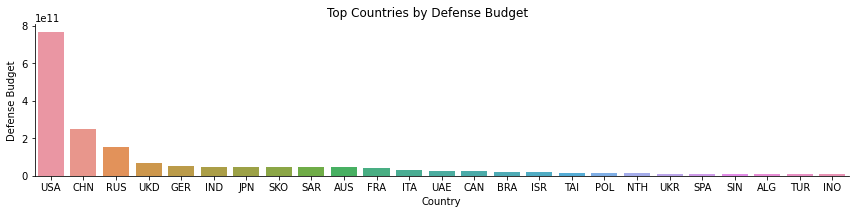

In [4]:
# Plots the countries by defense budget.
p = sns.catplot(kind='bar', data=df, x='country_code', y='defense_budget', height=3, aspect=4)
(p.set_axis_labels("Country", "Defense Budget"))  
p.fig.suptitle('Top Countries by Defense Budget')

### Clearly USA has the highest defense budget. Now let's further explore what drives the defense budget on Train data frame.

In [5]:
# splits the data
df = prepare.split_military(df)

Train: 14 rows, 37 cols
Validate: 6 rows, 37 cols
Test: 5 rows, 37 cols


In [6]:
train, validate, test = df
train.shape

(14, 37)

In [7]:
train.head(25).T

,22,26,104,98,58,17,132,114,44,112,130,103,56,41
country,Canada,China,Saudi Arabia,Poland,Japan,Brazil,United States,Spain,Germany,South Korea,United Arab Emirates,Russia,Italy,France
country_code,CAN,CHN,SAR,POL,JPN,BRA,USA,SPA,GER,SKO,UAE,RUS,ITA,FRA
active_personnel,70000,2000000,225000,120000,240000,360000,1390000,120000,184000,555000,65000,850000,170000,205000
air_carriers,0,3,0,0,4,1,20,1,0,2,0,1,2,4
armored_vehicles,1534,35000,6202,4786,5500,1958,45193,5033,9217,13990,9255,30122,6908,6558
arty,163,5854,2523,609,694,682,2837,236,121,6894,259,14145,162,214
attack_aircraft,0,652,115,30,142,89,1693,35,130,202,50,1283,154,69
avail_manpower,16315589,754864769,18087554,18711097,53615536,108857163,147399295,21739869,36755601,25857581,5716835,69737187,28075664,29957055
corvettes,0,70,4,2,6,2,22,0,5,11,9,86,0,0
defense_budget,23550574382,250240000000,46000000000,14500000000,47482740000,18785000000,770000000000,11750000000,50300000000,46320000000,25266000000,154000000000,29198401050,40900000000


<AxesSubplot:>

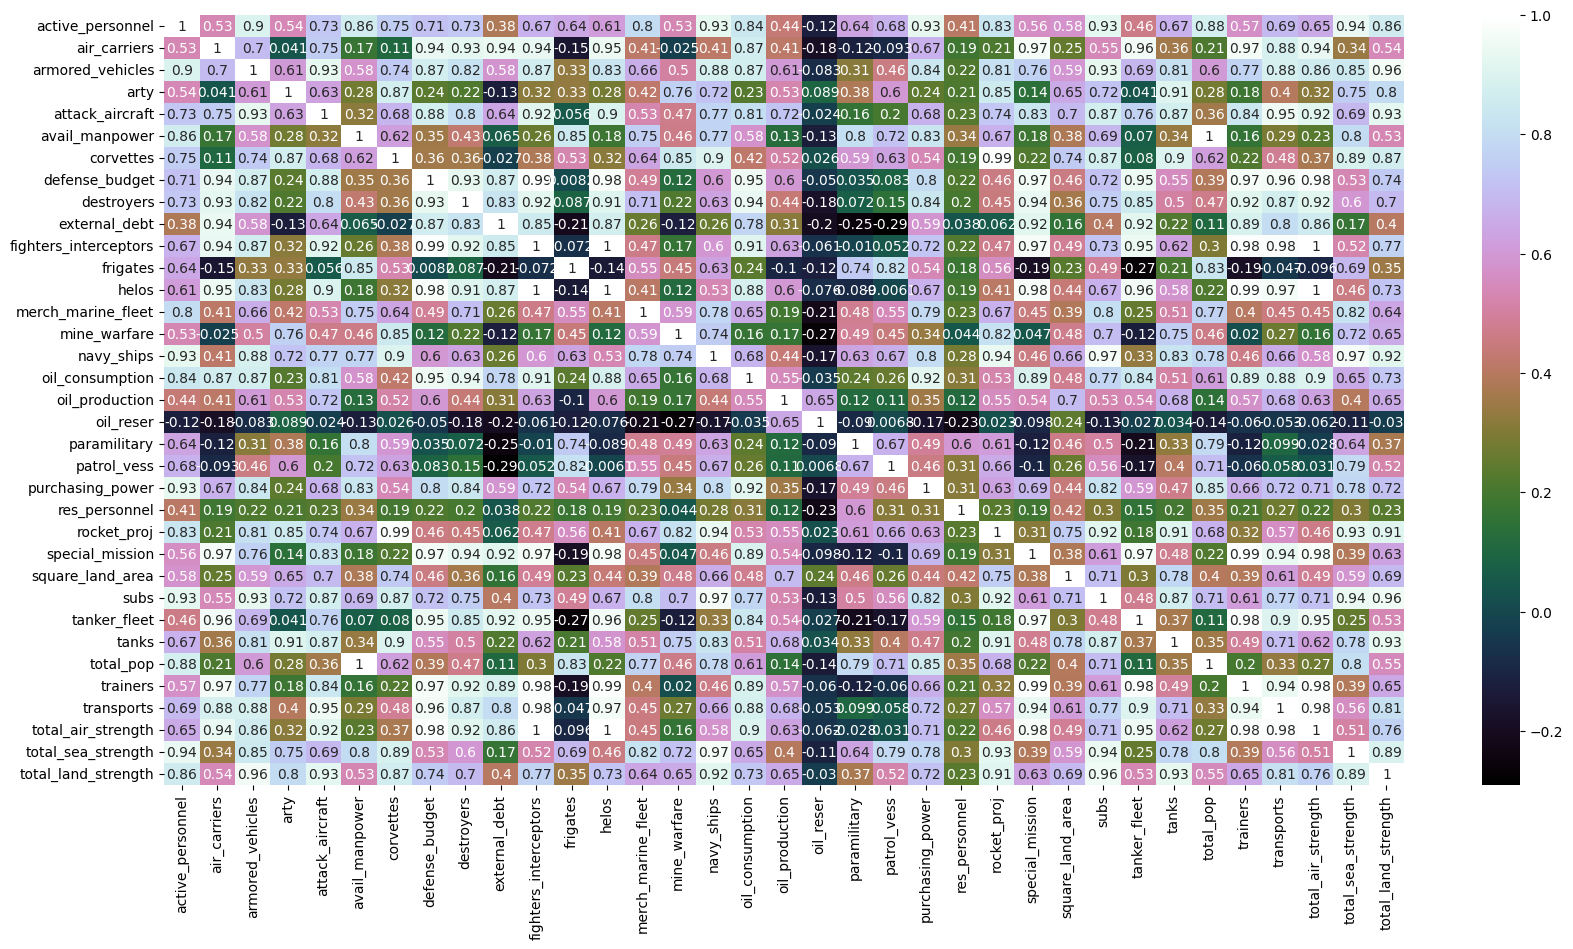

In [8]:
# Using heatmap visualize relationships between variables in high dimensional space.
plt.figure(figsize=(20, 10))
sns.heatmap(train.corr(),annot=True, cmap='cubehelix')

### Now let's visualise the relationships between defense budget and other added features.

Text(0.5, 1.0, 'Active Personnel by Defense Budget')

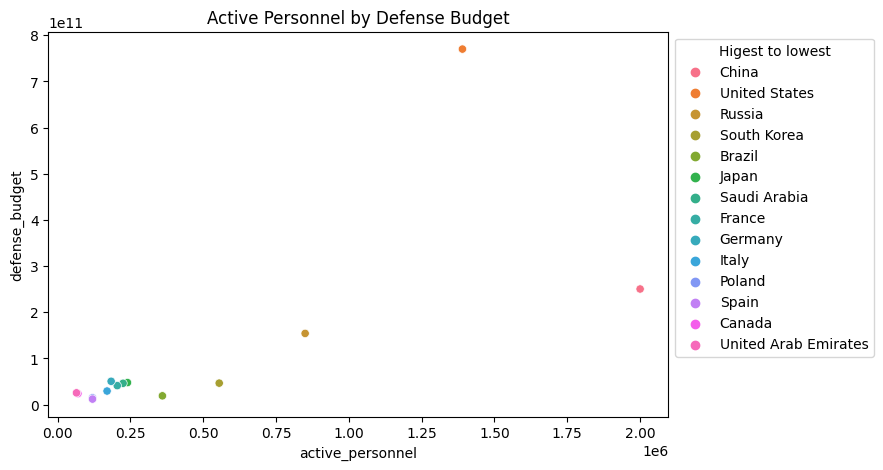

In [9]:
# plots total population by defense budget with hue of country.
plt.figure(figsize = (8,5))
sns.scatterplot(x='active_personnel', y='defense_budget', hue='country',
                data=train.sort_values('active_personnel',ascending=False))
plt.legend(loc = 2, bbox_to_anchor = (1,1), title='Higest to lowest')
plt.title("Active Personnel by Defense Budget")

Text(0.5, 1.0, 'Air Strength by Defense Budget')

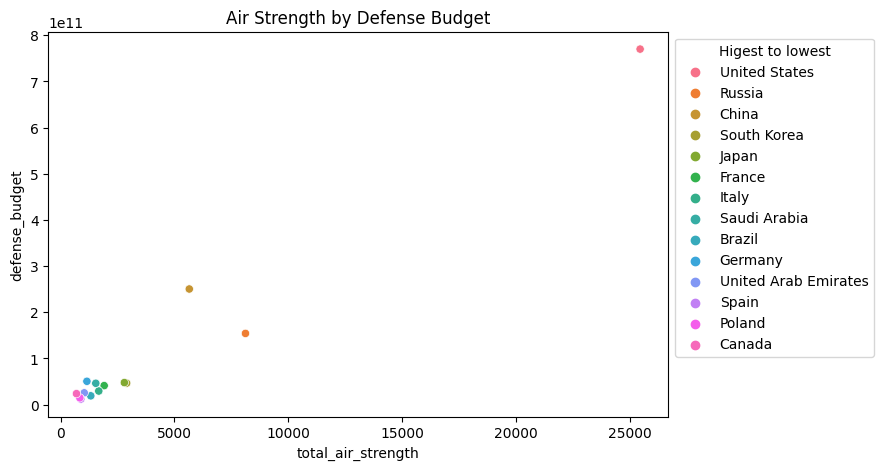

In [10]:
# plots air strength by defense budget with hue of country.
plt.figure(figsize = (8,5))
sns.scatterplot(x='total_air_strength', y='defense_budget', hue='country',
                data=train.sort_values('total_air_strength',ascending=False))
plt.legend(loc = 2, bbox_to_anchor = (1,1), title='Higest to lowest')
plt.title("Air Strength by Defense Budget")

Text(0.5, 1.0, 'Total Sea Strength by Defense Budget')

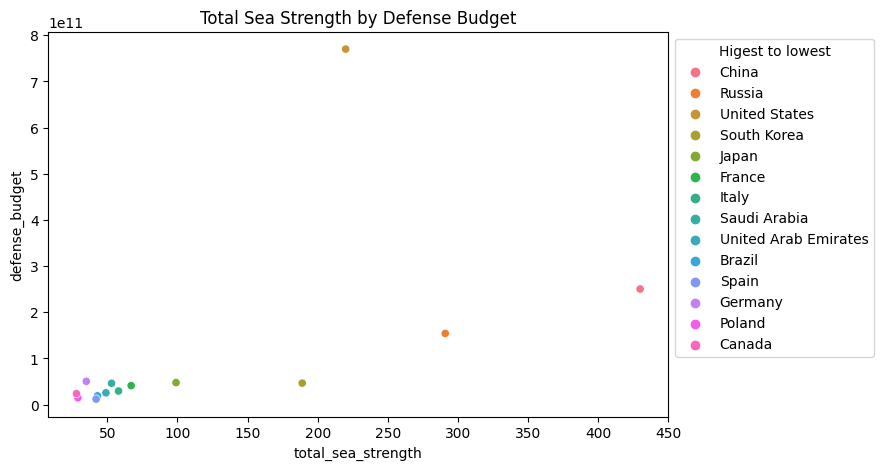

In [11]:
# plots total sea strength by defense budget with hue of country.
plt.figure(figsize = (8,5))
sns.scatterplot(x='total_sea_strength', y='defense_budget', hue='country',
                data=train.sort_values('total_sea_strength',ascending=False))
plt.legend(loc = 2, bbox_to_anchor = (1,1), title='Higest to lowest')
plt.title("Total Sea Strength by Defense Budget")

Text(0.5, 1.0, 'Total Land Strength by Defense Budget')

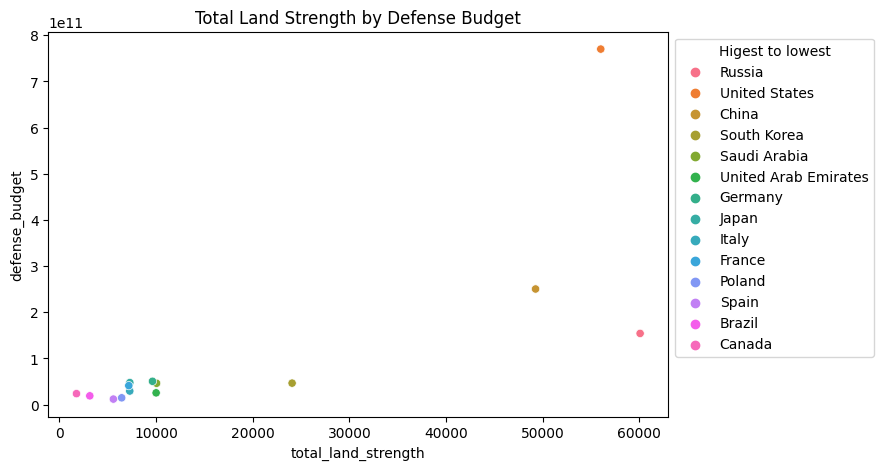

In [12]:
# plots total land strength by defense budget with hue of country.
plt.figure(figsize = (8,5))
sns.scatterplot(x='total_land_strength', y='defense_budget', hue='country',
                data=train.sort_values('total_land_strength',ascending=False))
plt.legend(loc = 2, bbox_to_anchor = (1,1), title='Higest to lowest')
plt.title("Total Land Strength by Defense Budget")

### Based off these several visualizations, USA, Russia, and China are always in the top three. Lets create a new dataframe that ranks each individual feature from 1 being the highest to 14 being the lowest.

In [13]:
# ranks the countries by feature
rank1=train.rank(ascending=False,method='min')
rank1['country']=train['country']
rank1['country_code']=train['country_code']

# Ranks each feature of train (14)  in order by defense budgets
rank2=rank1.sort_values('defense_budget', ascending=True).head(14)
rank2=rank2.set_index('country_code')
rank2=rank2.T
rank2=rank2.drop('country', axis=0)
rank2

country_code,USA,CHN,RUS,GER,JPN,SKO,SAR,FRA,ITA,UAE,CAN,BRA,POL,SPA
active_personnel,2.0,1.0,3.0,9.0,6.0,4.0,7.0,8.0,10.0,14.0,13.0,5.0,11.0,11.0
air_carriers,1.0,4.0,7.0,10.0,2.0,5.0,10.0,2.0,5.0,10.0,10.0,7.0,10.0,7.0
armored_vehicles,1.0,2.0,3.0,6.0,10.0,4.0,9.0,8.0,7.0,5.0,14.0,13.0,12.0,11.0
arty,4.0,3.0,1.0,14.0,6.0,2.0,5.0,11.0,13.0,9.0,12.0,7.0,8.0,10.0
attack_aircraft,1.0,3.0,2.0,7.0,6.0,4.0,8.0,10.0,5.0,11.0,14.0,9.0,13.0,12.0
avail_manpower,2.0,1.0,4.0,6.0,5.0,9.0,12.0,7.0,8.0,14.0,13.0,3.0,11.0,10.0
corvettes,3.0,2.0,1.0,7.0,6.0,4.0,8.0,11.0,11.0,5.0,11.0,9.0,9.0,11.0
defense_budget,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0,14.0
destroyers,1.0,2.0,4.0,8.0,3.0,5.0,8.0,6.0,7.0,8.0,8.0,8.0,8.0,8.0
external_debt,1.0,8.0,10.0,3.0,4.0,11.0,14.0,2.0,5.0,13.0,7.0,9.0,12.0,6.0


### Which features is USA rank as number 1?

In [16]:
# takes the number one positions from ranked data frame for USA.
df_usa=pd.DataFrame(rank2[rank2['USA']==1.0].index)
df_usa.T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,air_carriers,armored_vehicles,attack_aircraft,defense_budget,destroyers,external_debt,fighters_interceptors,helos,oil_consumption,oil_production,special_mission,tanker_fleet,trainers,transports,total_air_strength


In [17]:
# lists the features where USA is ranked number 1.
np.array(df_usa[0])

array(['air_carriers', 'armored_vehicles', 'attack_aircraft',
       'defense_budget', 'destroyers', 'external_debt',
       'fighters_interceptors', 'helos', 'oil_consumption',
       'oil_production', 'special_mission', 'tanker_fleet', 'trainers',
       'transports', 'total_air_strength'], dtype=object)

## USA has 15 features where they are ranked No. 1!!! that is 43% of the selected features.

### Where does C-H-I-N-A stand?

In [18]:
# Lists the features where China is ranked number 1.
df_china=pd.DataFrame(rank2[rank2['CHN']==1.0].index)
np.array(df_china.T)

array([['active_personnel', 'avail_manpower', 'frigates',
        'merch_marine_fleet', 'navy_ships', 'paramilitary',
        'patrol_vess', 'purchasing_power', 'subs', 'total_pop',
        'total_sea_strength']], dtype=object)

### Where does Russia stand?

In [19]:
# Lists the features where Russia is ranked number 1.
df_russia=pd.DataFrame(rank2[rank2['RUS']==1.0].index)
np.array(df_russia.T)

array([['arty', 'corvettes', 'mine_warfare', 'rocket_proj',
        'square_land_area', 'tanks', 'total_land_strength']], dtype=object)